# GD14. 추론하는 인공지능

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

## 데이터 로드하기

In [ ]:
# 환경에 맞게 경로 수정
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')

In [ ]:
with tarfile.open(path) as tar:
    tar.extractall()
    tar.close()

In [ ]:
# 환경에 맞게 경로 수정
DATA_DIR = 'tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [ ]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

## 데이터 전처리

### 기본 전처리
* 데이터를 읽는 과정에서 스토리, 질문, 답변을 각각 분리 (supporting fact는 저장 X)

In [ ]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [ ]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [ ]:
# 저장하고 출력해보기
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

# train data: 10000개
print(len(train_stories))
print(len(train_questions))
print(len(train_answers))

# test data: 1000개
print(len(test_stories))
print(len(test_questions))
print(len(test_answers))

In [ ]:
# 임의의 스토리 출력해보기
train_stories[3878]

In [ ]:
# 상위 5개 질문 출력해보기
train_questions[:5]

In [ ]:
# 상위 5개 답변 출력해보기
train_answers[:5]

#### 토큰화
* 파이썬 버전에 따라 다르게 사용: https://github.com/keras-team/keras/issues/13248

In [ ]:
# 파이썬 버전에 따라 다르게 사용
def tokenize(sent):
    return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 
    # return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()] # python 3.6의 경우

* 주요 전처리 작업
    - 단어장 생성
    - 단어에서 정수로, 정수에서 단어로 맵핑하는 딕셔너리 생성
    - 그 과정에서 스토리와 질문의 가장 긴 거리 구하기
* 위 과정에서, 같은 스토리 내 여러 문장을 하나의 문장으로 통합

In [ ]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [ ]:
# 전처리 함수를 사용해 가장 긴 샘플의 길이 리턴
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [ ]:
# 단어장 출력해보기
print(word2idx)

In [ ]:
# 실제 변수로 사용할 단어장의 크기는 +1 (패딩 고려)
vocab_size = len(word2idx) + 1

In [ ]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

### 패딩, 정수 인코딩, 벡터화
* `vectorize()`
    - 현재 각 데이터는 전부 텍스트 데이터입니다. 이를 단어와 맵핑되는 정수로 인코딩해줍니다. 이 과정은 앞서 만들어놓은 word2idx를 활용합니다.
    - 스토리와 질문 데이터에 대해서 각각의 최대 길이로 패딩(padding)합니다. 이 과정은 앞서 계산해놓은 story_max_len과 question_max_len을 사용합니다.
    - 레이블에 해당되는 정답 데이터를 원-핫 인코딩합니다.

In [ ]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [ ]:
# 훈련 데이터와 테스트 데이터에 벡터화 수행
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [ ]:
# 변환된 결과의 크기 (shape) 확인
# (10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

## 메모리 네트워크 구현

In [ ]:
# 주요 하이퍼파라미터 정의

train_epochs = 120 # 에포크 횟수
batch_size = 32 # 배치 크기
embed_size = 50 # 임베딩 크기
lstm_size = 64 # LSTM의 크기
dropout_rate = 0.30 # 과적합 방지 기법인 드롭아웃 적용 비율

In [ ]:
# 입력을 담아두는 변수 정의
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

In [ ]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [ ]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [ ]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

In [ ]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

In [ ]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

In [ ]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

In [ ]:
# 모델 훈련

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = 'babi_memory_net/model.h5'
model.save(model_path)

In [ ]:
# 테스트 정확도 출력
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

In [ ]:
# 훈련 과정에서 기록해두었던 훈련 데이터, 검증 데이터의 정확도와 loss를 그래프로 출력

# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [ ]:
# 실제로 문제를 잘 맞추고 있는지 임의로 30개의 예측 결과 출력해보기
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

## 프로젝트: 한국어 QA 모델 만들기
* `e-28-korean.zip`: bAbI 데이터셋을 저자가 한국어로 변환한 한국어 버전의 bAbI 데이터셋 (https://wikidocs.net/85470)
   
> **주의** 기존 케라스 공식 문서의 babi_rnn, babi_memn 구현은 파이썬 3.6을 기준으로 하고 있으며, 파이썬 3.7에서는 정상동작 하지 않을 수 있습니다. 실습 시 참고하세요!

In [2]:
DATA_DIR = 'e-28-korean'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

In [3]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 15:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8


In [4]:
# 학습 데이터 전체 수 확인
total_count = 0

for line in lines:
    total_count += 1
    
print(total_count)

29985


In [5]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [6]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

# 저장하고 출력해보기
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

# train data: 10000개
print(len(train_stories))
print(len(train_questions))
print(len(train_answers))

# test data: 1000개
print(len(test_stories))
print(len(test_questions))
print(len(test_answers))

10000
10000
10000
1000
1000
1000


In [7]:
# 상위 5개 질문 출력해보기
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [8]:
# 상위 5개 답변 출력해보기
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

In [9]:
# 임의의 스토리 출력해보기
train_stories[3878]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.']

### 토크나이저 변경하기 (중요)
* 사람 이름 등을 위해 사용자 사전 추가: Customized Konlpy https://inspiringpeople.github.io/data%20analysis/ckonlpy/
   
```
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')
```

In [10]:
from ckonlpy.tag import Twitter

twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('필웅이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')

# twitter.morhps('은경이는 정원으로 복귀했습니다.')
# twitter.morphs('수종이는 어디야?')

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [11]:
def tokenize(sent):
    return twitter.morphs(sent) # 형태소 분석기로 변경

In [12]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

### 형태소 분석 후 불용어 처리하기

In [13]:
# 전처리 함수를 사용해 가장 긴 샘플의 길이 리턴
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [14]:
# 단어장 출력해보기
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [15]:
# 실제 변수로 사용할 단어장의 크기는 +1 (패딩 고려)
vocab_size = len(word2idx) + 1

In [16]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


### 벡터화

In [17]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [18]:
# 훈련 데이터와 테스트 데이터에 벡터화 수행
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [19]:
# 변환된 결과의 크기 (shape) 확인
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


### 한국어에서의 모델 정확도 확인해보기

In [20]:
# 주요 하이퍼파라미터 정의

train_epochs = 120 # 에포크 횟수
batch_size = 32 # 배치 크기
embed_size = 50 # 임베딩 크기
lstm_size = 64 # LSTM의 크기
dropout_rate = 0.30 # 과적합 방지 기법인 드롭아웃 적용 비율

In [21]:
# 입력을 담아두는 변수 정의
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 70), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 5), dtype=float32)


In [22]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [23]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [24]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential/dropout/cond/Identity:0", shape=(None, 70, 50), dtype=float32)
Input encoded c Tensor("sequential_1/dropout_1/cond/Identity:0", shape=(None, 70, 5), dtype=float32)
Question encoded Tensor("sequential_2/dropout_2/cond/Identity:0", shape=(None, 5, 50), dtype=float32)


In [25]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/truediv:0", shape=(None, 70, 5), dtype=float32)


In [26]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/transpose:0", shape=(None, 5, 70), dtype=float32)


In [27]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/concat:0", shape=(None, 5, 120), dtype=float32)


In [28]:
# 모델 훈련

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = 'babi_memory_net/model_ko.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 1.8909 - acc: 0.1718 - val_loss: 1.7920 - val_acc: 0.1490
Epoch 2/120
313/313 [==============================] - 1s 2ms/step - loss: 1.7065 - acc: 0.2572 - val_loss: 1.6746 - val_acc: 0.2740
Epoch 3/120
313/313 [==============================] - 1s 2ms/step - loss: 1.6316 - acc: 0.3112 - val_loss: 1.5773 - val_acc: 0.3450
Epoch 4/120
313/313 [==============================] - 1s 2ms/step - loss: 1.5281 - acc: 0.4015 - val_loss: 1.4439 - val_acc: 0.4640
Epoch 5/120
313/313 [==============================] - 1s 2ms/step - loss: 1.4565 - acc: 0.4451 - val_loss: 1.4206 - val_acc: 0.4740
Epoch 6/120
313/313 [==============================] - 1s 2ms/step - loss: 1.4069 - acc: 0.4593 - val_loss: 1.3906 - val_acc: 0.4860
Epoch 7/120
313/313 [==============================] - 1s 2ms/step - loss: 1.3689 - acc: 0.4749 - val_loss: 1.3375 - val_acc: 0.4980
Epoch 8/120
313/313 [==============================] - 1s 2ms/step - 

313/313 [==============================] - 1s 2ms/step - loss: 0.1384 - acc: 0.9494 - val_loss: 0.2187 - val_acc: 0.9210
Epoch 63/120
313/313 [==============================] - 1s 2ms/step - loss: 0.1257 - acc: 0.9554 - val_loss: 0.2883 - val_acc: 0.9130
Epoch 64/120
313/313 [==============================] - 1s 2ms/step - loss: 0.1161 - acc: 0.9580 - val_loss: 0.2076 - val_acc: 0.9170
Epoch 65/120
313/313 [==============================] - 1s 2ms/step - loss: 0.1141 - acc: 0.9600 - val_loss: 0.2171 - val_acc: 0.9220
Epoch 66/120
313/313 [==============================] - 1s 2ms/step - loss: 0.1107 - acc: 0.9611 - val_loss: 0.1897 - val_acc: 0.9320
Epoch 67/120
313/313 [==============================] - 1s 2ms/step - loss: 0.0954 - acc: 0.9661 - val_loss: 0.2189 - val_acc: 0.9340
Epoch 68/120
313/313 [==============================] - 1s 2ms/step - loss: 0.0887 - acc: 0.9704 - val_loss: 0.2031 - val_acc: 0.9330
Epoch 69/120
313/313 [==============================] - 1s 2ms/step - loss:

In [29]:
# 테스트 정확도 출력
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.1819 - acc: 0.9560

 테스트 정확도: 0.9560


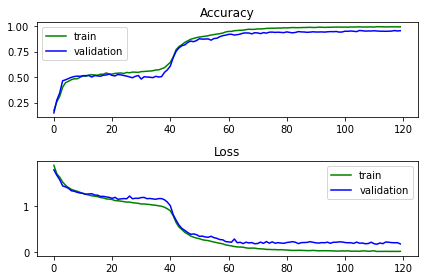

In [30]:
# 훈련 과정에서 기록해두었던 훈련 데이터, 검증 데이터의 정확도와 loss를 그래프로 출력

# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [31]:
# 실제로 문제를 잘 맞추고 있는지 임의로 30개의 예측 결과 출력해보기
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도      복도
필웅이 는 어디 야 ?        : 화장실     화장실
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 사무실     사무실
수종이 는 어디 야 ?        : 사무실     사무실
필웅이 는 어디 야 ?        : 부엌      부엌
필웅이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 사무실     사무실
필웅이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
은경이 는 어디 야 ?        : 부엌      부엌
은경이 는 어디 야 ?        : 정원      정원
은경이 는 어디 야 ?        : 부엌      부엌
수종이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 부엌      복도
필웅이 는 어디 야 ?        : 복도      복도
은경이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 사무실     사무실
경임이 는 어디 야 ?        : 복도      복도
수종이 는 어디 야 ?        : 침실      침실
경임이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
수종이 는 어디 야 ?        : 부엌      부엌


### 결론
* 토큰화에는 konlpy의 Twitter 형태소 분석기를 사용하였다.
* customized konlpy를 이용해, 데이터셋에서 잘못 인식할 만한 사람 이름 (필웅이, 은경이, 경임이, 수종이) 을 dictionary에 추가하였다.
* 불용어는 따로 제거하지 않았다.
* 하이퍼파라미터는 실습과 똑같이 진행하였다. (120 epochs, batch size 32, embedding size 50, lstm size 64, dropout rate 0.3)
* 불용어 제거 없이도 정확도가 95.6% 나오고, 그래프도 안정적인 편이어서 프로젝트를 종료했다. 임의의 30개 질문에 대해 예측 결과와 실제 값을 비교해봐도 29개는 맞는 값을 도출하고 있다.